# SKY2TRAVEL CHATBOT WITH NLTK

ETL SQUAD: <br>
Jessica López <br>
Alberto Padilla <br>
Ruben Tenreiro <br>
Marco Hernani <br>

The company Sky2travel requires our services, and does not hire us to make a transactional bot focused on facilitating the search for flights and travel for customers who request it to integrate it into mobile devices and different apps.

The goal is that customers with a text message, make a request and the bot is able to return the necessary information.

In addition, booking requests must be saved in Json format. 
be saved in Json format.

We import the libraries that We are going to need

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.chunk.regexp import *
from nltk.corpus import treebank
from nltk.tag.hmm import HiddenMarkovModelTagger
import pandas as pd
import unidecode

# For microphone use
import speech_recognition as sr

# For chatbot
from nltk.chat.util import Chat, reflections

# For program talking to the user
import pyttsx3

Creation of the data that We are going to use which contain the names of valid cities, airlines and months.

In [2]:
airlines = [ "American Airlines", "Delta Air Lines", "United Airlines", "Southwest Airlines", "Alaska Airlines", "JetBlue Airways", "Spirit Airlines", "Frontier Airlines", "Hawaiian Airlines", "Allegiant Air", "Sun Country Airlines", "Virgin America", "Mesa Airlines", "Republic Airways", "SkyWest Airlines" ]
airlines = list(map(lambda x: x.lower(), airlines))
airlines

['american airlines',
 'delta air lines',
 'united airlines',
 'southwest airlines',
 'alaska airlines',
 'jetblue airways',
 'spirit airlines',
 'frontier airlines',
 'hawaiian airlines',
 'allegiant air',
 'sun country airlines',
 'virgin america',
 'mesa airlines',
 'republic airways',
 'skywest airlines']

In [3]:
months = ["enero", "febrero", "marzo", "abril", "mayo", "junio", "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"]
months

['enero',
 'febrero',
 'marzo',
 'abril',
 'mayo',
 'junio',
 'julio',
 'agosto',
 'septiembre',
 'octubre',
 'noviembre',
 'diciembre']

In [4]:
cities = pd.read_csv("Files/cities.csv", names = ["ciudad"])
cities = list(cities['ciudad'].str.lower())
cities[:10]

['new york',
 'los angeles',
 'chicago',
 'dallas',
 'philadelphia',
 'houston',
 'toronto',
 'washington',
 'miami',
 'atlanta']

## Functions definitions

In [5]:
def detector_word(_sentence, _special_words):
    """Returns the words that are in special words
    _special_words: a list with all the proper nouns
    _sentence: a string that contains the sentence to process"""
    detected_words = []
    for word in _special_words:
        if(word.lower() in _sentence.lower()):
            detected_words.append(word.lower())
    return detected_words

In [6]:
def get_tokens(_sentence):
    """Tokenizes a sentence
    _frase: sentence to tokenize
    returns: a list with the words of sentence"""
    _sentence = unidecode.unidecode(_sentence)
    cities_detected = detector_word(_sentence, cities)
    airlines_detected = detector_word(_sentence, airlines)
    months_detected = detector_word(_sentence, months)
    sentence_slicer = [*cities_detected[:2],*airlines_detected, *months_detected]
    
    special_words_indexes = []

    for word in sentence_slicer:
        for i in range(len(_sentence)-len(word)+1):
            if(word.lower() == _sentence[i:i+len(word)].lower()):
                special_words_indexes.append((i, word))

    #Sorts the list of tuples
    special_words_indexes.sort(key=lambda x: x[0])

    little_bits = []
    i= 0
    for x in special_words_indexes:
        #Get substring from i to beggining of special words
        part_tokens = word_tokenize(_sentence[i:x[0]], "spanish")
        part_tokens = [word.lower() for word in part_tokens if word.isalnum()]
        little_bits.extend([*part_tokens, x[1]])
        i = x[0] + len(x[1])

    #In case there is a part left to be tokenized after the last special words
    if(i < len(_sentence)-1):
        part_tokens = word_tokenize(_sentence[i:], "spanish")
        part_tokens = [word.lower() for word in part_tokens if word.isalnum()]
        little_bits.extend([*part_tokens])

    return little_bits


In [7]:
def get_tree(tokens):
    """Creates a tree with the labels with a list of tokens"""
    return parser.parse(tokens)

In [8]:
def get_json(_sentence):
    """Gets a sentence and returns a json"""
    tree_sentence_tag = get_tree(hmm.tag(get_tokens(_sentence)))
    semi_query = []
    for x in tree_sentence_tag[:]:
        if (type(x) == Tree):
            semi_query.append((x.label(),x[:]))

    json_query = {'numeroBilletes': '', 'Origen': '', 'Destino': '', 'fecha': '', 'aerolinea': ''}

    for x in semi_query:
        if(x[0] == 'fecha'):
            fecha_vuelo = list(map(lambda t: t[0], x[1]))
            json_query['fecha'] = " ".join(fecha_vuelo)
        else:
            json_query[x[0]] = x[1][0][0]

    return(json_query)

In [9]:
def get_voice():
    """Asks for a the microphone record and returns an string"""
    # Crear instancia del objeto reconocedor
    r = sr.Recognizer()
    # Utilizar el micrófono del sistema como fuente de audio
    with sr.Microphone() as source:
        # Ajustar nivel de ruido ambiental
        r.adjust_for_ambient_noise(source)
        print("Di algo...")
        # Escuchar audio del usuario
        audio = r.listen(source)
        
        # Convertir audio a texto utilizando el reconocimiento de voz de Google
        user_sentence = r.recognize_google(audio, language='es-ES')
        
        user_sentence = unidecode.unidecode(user_sentence)
        
        return user_sentence

In [10]:
def talk_to_user(s, engine):
    """Gets an string an says it"""
    engine.say(s)
    engine.runAndWait()

In [11]:
def query_correction(_query, engine):
    """Corrects the json values"""
    
    while(_query["aerolinea"] not in airlines):
        talk_to_user('Por favor, introduce el nombre de la aerolinea: ', engine)
        _query["aerolinea"] = get_voice().lower()
        
    while(_query["Origen"] not in cities):
        talk_to_user('Por favor, introduce la ciudad de origen: ', engine)
        _query["Origen"] = get_voice().lower()

    while(_query["Destino"] not in cities):
        talk_to_user('Por favor, introduce la ciudad de destino: ', engine)
        _query["Destino"] = get_voice().lower()

    while(len(_query["fecha"]) == 0):
        talk_to_user('Por favor, introduce la fecha: ', engine)
        _query["fecha"] = get_voice().lower()    
    else:
        print('Gracias, procesando tu peticion...')

In [12]:
def sky2travel_chat(engine):
    """Runs the chatbot"""

    quit_words = ['n', 'no']
    q = ''

    talk_to_user("Hola, bienvenido a sky2travel, como te puedo ayudar?", engine)

    while(q not in quit_words):
        user_sentence = get_voice()
        json_sentence = get_json(user_sentence)

        query_correction(json_sentence, engine)
        
        print(f"""Perfecto. Voy a realizar la búsqueda de {json_sentence["numeroBilletes"]} billetes para tu viaje desde 
        {json_sentence["Origen"]} a {json_sentence["Destino"]} para el {json_sentence["fecha"]}
        con {json_sentence["aerolinea"]}.""")

        q = input("Quieres continuar s/n : \n")

In [13]:
train_corpus = [
 [('quisiera', "vmip000"),
  ('reservar', "vmn0000"),
  ('3', 'Z'),
  ('billetes', "ncmp000"),
  ('de', "sps00"),
  ('new york', "np00000"),
  ('a', "sps00"),
  ('los angeles',  "np00000"),
  ('el', "da0ms0"),
  ('13','Z'),              
  ('de', "sps00"),
  ('mayo','mes'),
  ('con', 'sps00'),
  ('ryanair', 'np00000')
  ],
    
  [("me", "pp000000"),
  ("gustaría", "vmic000"),
  ("reservar", "vmn0000"),
  ("2", "Z"),
  ("billetes", "ncmp000"),
  ("de", "sps00"),
  ("chicago", "np00000"),
  ("a", "sps00"),
  ("miami", "np00000"),
  ("para", "sps00"),
  ("el", "da0ms0"),
  ("próximo", "tiempo"),
  ("fin", "ncms000"),
  ("de", "sps00"),
  ("semana", "tiempo"),
  ("con", "sps00"),
  ("allegian air", "np00000")],
                
  [("tienen", "vmip3p0"),
  ("vuelos", "ncmp000"),
  ("de", "sps00"),
  ("san francisco", "np00000"),
  ("a", "sps00"),
  ("seattle", "np00000"),
  ("para", "sps00"),
  ("el", "da0ms0"),
  ('20','Z'),
  ("de", "sps00"),
  ("abril", "mes"), 
  ('con', 'sps00'),
  ('Iberia', 'np00000')],

  [("quiero", "vmip1s0"), 
  ("reservar", "vmn0000"), 
  ("3", "Z"), 
  ("billetes", "ncmp000"), 
  ("de", "sps00"), 
  ("dallas", "np00000"),
  ("a", "sps00"), 
  ("las vegas", "np00000"), 
  ("para", "sps00"), 
  ("el", "da0ms0"), 
  ("4", "Z"), 
  ("de", "sps00"),
  ("abril", "mes"),
  ("con", "sps00"), 
  ("spirit airlines", "np00000")],
                
  [("necesito", "vmip1s0"),
  ("2", "Z"), 
  ("billetes", "ncmp000"),  
  ("de", "sps00"), 
  ("boston", "np00000"), 
  ("a", "sps00"), 
  ("denver", "np00000"), 
  ("el", "da0ms0"), 
  ("6", "Z"), 
  ("de", "sps00"), 
  ("junio", "mes"),
  ("con", "sps00"), 
  ("allegiant air", "np00000")],

[("podría", "vmip3s0"), 
 ("reservar", "vmn0000"), 
 ("1", "Z"), 
 ("billete", "ncms000"),   
 ("de", "sps00"), 
 ("american airlines", "np00000"), 
 ("de", "sps00"), 
 ("washington d.c.", "np00000"), 
 ("a", "sps00"), 
 ("new orleans", "np00000"), 
 ("para", "sps00"), 
 ("el", "da0ms0"), 
 ("30", "Z"), 
 ("de", "sps00"), 
 ("febrero", "mes"),  
 ('con', 'sps00'),
 ('easyjet', 'np00000')],

[("me", "pp1cs000"), 
 ("gustaría", "vmis1s0"), 
 ("1", "Z"), 
 ("billete", "ncms000"), 
 ("de", "sps00"), 
 ("atlanta", "np00000"), 
 ("a", "sps00"), 
 ("orlando", "np00000"), 
 ("el", "da0ms0"), 
 ("15", "Z"), 
 ("de", "sps00"), 
 ("mayo", "mes"), 
 ("con", "sps00"), 
 ("hawaiian airlines", "np00000")],

[("tienen", "vmip3p0"),
 ("4", "Z"),
 ("vuelos", "ncmp000"), 
 ("de", "sps00"), 
 ("houston", "np00000"), 
 ("a", "sps00"), 
 ("phoenix", "np00000"), 
 ("para", "sps00"),
 ("el", "da0ms0"),
 ("7", "Z"),
 ("de", "sps00"),
 ("mayo", "mes"),
 ("con", "sps00"), 
 ("virgin america", "np00000")],

[("tienen", "vmip3p0"), 
 ('25', 'Z'),
 ("vuelos", "ncmp000"),
 ("de", "sps00"), 
 ("houston", "np00000"), 
 ("a", "sps00"), 
 ("phoenix", "np00000"), 
 ("para", "sps00"),
 ("el", "da0ms0"),
 ("7", "Z"),
 ("de", "sps00"),
 ("mayo", "mes"),
 ("con", "sps00"), 
 ("virgin america", "np00000")],

[('quiero', 'vmip3p0'),
  ('reservar', 'vmic000'),
  ('un', 'sps00'),
  ('vuelo', 'ncms000'),
  ('desde', 'sps00'),
  ('madrid', 'np00000'),
  ('a', 'sps00'),
  ('new york', 'np00000'),
  ('york', 'np00000'),
  ('para', 'sps00'),
  ("el", "da0ms0"),
  ("8", "Z"),
  ("de", "sps00"),
  ("diciembre", "mes"),
  ('con', 'sps00'),
  ('air europa', 'np00000')],
    
 [('necesito', 'pp000000'),
  ('comprar', 'vmic000'),
  ('1', 'Z'),
  ('billete', 'ncms000'),
  ('de', 'sps00'),
  ('valencia', 'np00000'),
  ('a', 'sps00'),
  ('paris', 'np00000'),
  ('para', 'sps00'),
  ("el", "da0ms0"),
  ("14", "Z"),
  ("de", "sps00"),
  ("mayo", "mes"),
  ('con', 'sps00'),
  ('SAS', 'np00000')],
    
 [('quiero', 'vmis1s0'),
  ('comprar', 'vmic000'),
  ('1', 'Z'),
  ('billete', 'ncms000'),
  ('de', 'sps00'),
  ('valencia', 'np00000'),
  ('a', 'sps00'),
  ('madrid', 'np00000'),
  ('para', 'sps00'),
  ('el', 'da0ms0'),
  ("28", "Z"),
  ("de", "sps00"),
  ("septiembre", "mes"),
  ('con', 'sps00'),
  ('Iberia', 'np00000')],
    
 [('quiero', 'vmis1s0'),
  ('2', 'Z'),
  ('vuelo', 'ncms000'),
  ('de', 'sps00'),
  ('barcelona', 'np00000'),
  ('a', 'sps00'),
  ('new york', 'np00000'),
  ('para', 'sps00'),
  ('el', 'da0ms0'),
  ("7", "Z"),
  ("de", "sps00"),
  ("abril", "mes"),
  ('con', 'sps00'),
  ('vueling', 'np00000')],
    
 [('necesito', 'vmip1s0'),
 ('2', 'Z'),
 ('billetes', 'ncmp000'),
 ('para', 'sps00'),
 ('ir', 'van0000'),
 ('desde', 'sps00'),
 ('madrid', 'np00000'),
 ('a', 'sps00'),
 ('tokio', 'np00000'),
 ('para', 'sps00'),
 ('el', 'da0ms0'),
 ("17", "Z"),
 ("de", "sps00"),
 ("octubre", "mes"),
 ('con', 'sps00'),
 ('ryanair', 'np00000')],
              
[('dame', 'vmip1s0'),
 ('3', 'Z'),
 ('tickets', 'ncmp000'),
 ('desde', 'sps00'),
 ('madrid', 'np00000'),
 ('a', 'sps00'),
 ('barcelona', 'np00000'),
 ('para', 'sps00'),
 ('el', 'da0ms0'),
 ("31", "Z"),
 ("de", "sps00"),
 ("febrero", "mes"),
 ('con', 'sps00'),
 ('easyjet', 'np00000')],

 [('necesito', 'vmn0000'),
 ('1', 'Z'),
 ('vuelo', 'ncms000'),
 ('de', 'spcms'),
 ('salt lake city', 'np00000'),
 ('a', 'sps00'),
 ('los angeles', 'np00000'),
 ('para', 'sps00'),
 ('el', 'da0ms0'),
 ("1", "Z"),
 ("de", "sps00"),
 ("agosto", "mes"),
 ('con', 'sps00'),
 ('easyjet', 'np00000')],
                
[('necesito', 'vmn0000'),
 ('3', 'Z'),
 ('vuelos', 'ncmp000'),
 ('de', 'sps00'),
 ('minneapolis', 'np00000'),
 ('a', 'sps00'),
 ('dallas', 'np00000'),
 ('para', 'sps00'),
 ('el', 'da0ms0'),
 ("13", "Z"),
 ("de", "sps00"),
 ("septiembre", "mes"),
 ('con', 'sps00'),
 ('emirates', 'np00000')],
                
 [('necesito', 'vmn0000'),
 ('un', 'di0ms0'),
 ('vuelo', 'ncms000'),
 ('de', 'spcms'),
 ('salt lake city', 'np00000'),
 ('a', 'sps00'),
 ('dallas', 'np00000'),
 ('para', 'sps00'),
 ('el', 'da0ms0'),
 ("10", "Z"),
 ("de", "sps00"),
 ("marzo", "mes"),
 ('con', 'sps00'),
 ('lufthansa', 'np00000')],

[('quiero', 'vmic000'),
 ('3', 'Z'),
 ('billetes', 'ncms000'),
 ('de', 'sps00'),
 ('bogota', 'np00000'),
 ('a', 'sps00'),
 ('la paz', 'np00000'),
 ('para', 'sps00'),
 ('el', 'da0ms0'),
 ("6", "Z"),
 ("de", "sps00"),
 ("noviembre", "mes"),
 ('con', 'sps00'),
 ('vueling', 'np00000')],
    
 [('necesito', 'vmn0000'),
 ('1', 'Z'),
 ('vuelo', 'ncms000'),
 ('de', 'spcms'),
 ('scranton', 'np00000'),
 ('a', 'sps00'),
 ('new york', 'np00000'),
 ('para', 'sps00'),
 ('el', 'da0ms0'),
 ("19", "Z"),
 ("de", "sps00"),
 ("julio", "mes"),
 ('con', 'sps00'),
 ('etl airlines', 'np00000')]]

We train a HiddenMarkov model with the `train_corpus`

In [14]:
hmm = HiddenMarkovModelTagger.train(train_corpus)

We check that there is 20 tagged sentences

In [15]:
len(train_corpus)

20

We check that our model tokenizes correctly

In [16]:
hmm.tag(get_tokens("Quiero 2 billetes de Barcelona a Madrid para el 15 de agosto con SAS"))

[('quiero', 'vmip1s0'),
 ('2', 'Z'),
 ('billetes', 'ncmp000'),
 ('de', 'sps00'),
 ('barcelona', 'np00000'),
 ('a', 'sps00'),
 ('madrid', 'np00000'),
 ('para', 'sps00'),
 ('el', 'da0ms0'),
 ('15', 'Z'),
 ('de', 'sps00'),
 ('agosto', 'mes'),
 ('con', 'sps00'),
 ('sas', 'np00000')]

## Definition of the rules

In [17]:
sentences_rules = r"""

Origen: <sp.*> {<np.*> <np.*> <np.*> | <.*> <np.*> | <np.*>} <sp.*>

Destino: <Origen> <sp.*> {<np.*> <np.*> <np.*> | <.*> <np.*> | <np.*>}

numeroBilletes: {<Z>} <nc.*>  

fecha: {<Z> <sp.*><mes>}

aerolinea: <fecha> <sp.*> {<np.*>}

"""

parser = nltk.RegexpParser(sentences_rules)

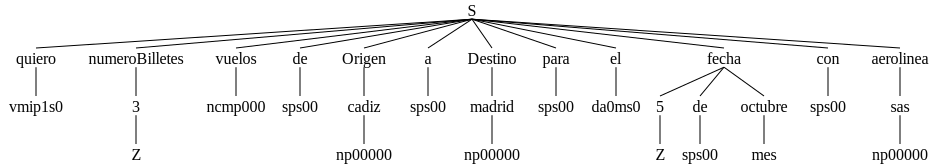

In [18]:
user_query = "Quiero 3 vuelos de Cadiz a Madrid para el 5 de octubre con SAS"
tree_query = get_tree(hmm.tag(get_tokens(user_query)))
tree_query

## Chatbot

In [19]:
engine = pyttsx3.init()
#Speed setting
engine.setProperty('rate', 140)

#Language settings
engine.setProperty('voice', 'spanish')

In [20]:
sky2travel_chat(engine)
#"Quiero 3 vuelos de Cadiz a Madrid para el 5 de octubre con SAS"

Di algo...
result2:
{   'alternative': [   {   'confidence': 0.95804894,
                           'transcript': 'los de Cádiz a Madrid para el cinco '
                                         'de octubre'},
                       {   'transcript': 'los de Cádiz a Madrid para el cinco '
                                         'de octubre con'},
                       {   'transcript': 'los de Cádiz a Madrid para el cinco '
                                         'de octubre y'}],
    'final': True}
Di algo...
result2:
{   'alternative': [   {   'confidence': 0.95477629,
                           'transcript': 'American Airlines'},
                       {'transcript': 'American airlands'},
                       {'transcript': 'American airland'}],
    'final': True}
Di algo...
result2:
{   'alternative': [{'confidence': 0.958049, 'transcript': 'Chicago'}],
    'final': True}
Di algo...
result2:
{   'alternative': [{'confidence': 0.958049, 'transcript': 'New York'}],
    'final': T

## Conclusions

1- It is not practical to create a chatbot from scratch. It is better to use already created NLP models and adapt them.

2- A large amount of data is needed, since the structure of the sentences can be very diverse. We have understood that 20 sentences do not adapt to reality, and we have had to adapt the sentences in a well-defined and pre-established context.

3- The need to know the language with which we are going to deal is fundamental, and we have understood the difficulty of dealing with colloquial expressions.